<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>

<span style="font-size:16px;"> The objective of this notebook is to learn how to use FlexzBoost and verify its funcionality. To achieve this I executed FlexzBoost using cross-matched data from two spectroscopic catalog,VIPERS and GAMA, with DR2. </span>


# Environment creation

```bash
conda create rail_env
source activate rail_env
pip install pz-rail-flexzboost
python -m ipykernel install --user --name=rail_env
```

# Flexzboost on DR2 data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys

from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp

from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Reading spectroscopic catalog cross-matched

Choose between GAMA or VIPERS!

In [3]:
catalog = 'VIPERS' # Choose GAMA or VIPERS
training_csv = pd.read_csv(f'/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/training.control_{catalog}', sep=' ')
validation_csv = pd.read_csv(f'/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/validation.control_{catalog}', sep=' ')

In [4]:
z_max = max(max(training_csv['#zs']),max(validation_csv['#zs'])) #Selecting the max and min for FzB config
z_min = min(min(training_csv['#zs']),min(validation_csv['#zs']))

In [5]:
training_csv = training_csv.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)

In [6]:
training_csv

,#zs,g,r,i,z,y,eg,er,ei,ez,ey
0,0.8322,22.896608,22.395735,21.911516,21.816675,21.645422,0.051414,0.040181,0.044053,0.084790,0.200469
1,0.7499,23.347048,22.369768,21.729416,21.278749,21.759733,0.113855,0.060167,0.060902,0.072633,0.330481
2,0.5797,22.775026,21.594164,20.938263,20.507381,20.537544,0.071338,0.030493,0.035033,0.034061,0.110403
3,0.7642,23.150194,22.375637,21.876324,21.628412,21.961998,0.080405,0.050262,0.051865,0.092243,0.318340
4,0.8818,23.191761,22.594900,22.015545,21.719957,21.866032,0.059108,0.045689,0.048919,0.069947,0.236756
...,...,...,...,...,...,...,...,...,...,...,...
21868,0.6118,23.400440,22.284716,21.674662,21.704668,21.983829,0.123238,0.055362,0.050605,0.111953,0.384974
21869,0.8852,22.733706,22.345627,21.724373,21.527571,22.060930,0.047393,0.044239,0.043205,0.065410,0.302581
21870,0.5929,23.293682,22.404408,21.981777,21.841465,22.328255,0.088967,0.060065,0.076798,0.105736,0.754651
21871,0.5360,24.070980,22.079430,21.347004,20.876230,20.886198,0.146944,0.034227,0.025868,0.036776,0.116476


### Changing columns name according to RAIL

In [7]:
columns_map = {
"g": "mag_g_lsst",
"eg": "mag_err_g_lsst",
"r": "mag_r_lsst",
"er": "mag_err_r_lsst",
"i": "mag_i_lsst",
"ei": "mag_err_i_lsst",
"y": "mag_y_lsst",
"ey": "mag_err_y_lsst",
"z": "mag_z_lsst",
"ez": "mag_err_z_lsst",
"#zs": "redshift"
}


col_remapper_train = ColumnMapper.make_stage(name='col_remapper_train', columns=columns_map)
col_remapper_valitation = ColumnMapper.make_stage(name='col_remapper_validation', columns=columns_map)

In [8]:
training_sample = col_remapper_train(training_csv)
validation_sample = col_remapper_train(validation_csv)


Inserting handle into data store.  input: None, col_remapper_train
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train


In [9]:
col_remapper_train.get_data("output")

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.8322,22.896608,22.395735,21.911516,21.816675,21.645422,0.051414,0.040181,0.044053,0.084790,0.200469
1,0.7499,23.347048,22.369768,21.729416,21.278749,21.759733,0.113855,0.060167,0.060902,0.072633,0.330481
2,0.5797,22.775026,21.594164,20.938263,20.507381,20.537544,0.071338,0.030493,0.035033,0.034061,0.110403
3,0.7642,23.150194,22.375637,21.876324,21.628412,21.961998,0.080405,0.050262,0.051865,0.092243,0.318340
4,0.8818,23.191761,22.594900,22.015545,21.719957,21.866032,0.059108,0.045689,0.048919,0.069947,0.236756
...,...,...,...,...,...,...,...,...,...,...,...
21868,0.6118,23.400440,22.284716,21.674662,21.704668,21.983829,0.123238,0.055362,0.050605,0.111953,0.384974
21869,0.8852,22.733706,22.345627,21.724373,21.527571,22.060930,0.047393,0.044239,0.043205,0.065410,0.302581
21870,0.5929,23.293682,22.404408,21.981777,21.841465,22.328255,0.088967,0.060065,0.076798,0.105736,0.754651
21871,0.5360,24.070980,22.079430,21.347004,20.876230,20.886198,0.146944,0.034227,0.025868,0.036776,0.116476


## FlexzBoost Configurations


In [10]:
fz_dict = dict(zmin=z_min, zmax=z_max, nzbins=201,
               trainfrac=0.7, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=35, basis_system='cosine',
               bands = ['mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_g_lsst':24.7,'mag_r_lsst':24.4,'mag_i_lsst':23.8,'mag_z_lsst':23.1,'mag_y_lsst':21.7,},
               hdf5_groupname='',
               regression_params={'max_depth': 8,'objective':'reg:squarederror'})

fz_modelfile = 'demo_FZB_model.pkl'

In [11]:

from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile, **fz_dict)



## Training (LONG TIME TO RUN)

If you just want to see the results you can skip this cell.

In [12]:
inform_pzflex.inform(training_sample)

stacking some data...
read in training data
fit the model...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

Inserting handle into data store.  model_inform_fzboost: inprogress_demo_FZB_model.pkl, inform_fzboost


## Validation (LONG TIME TO RUN)

In [13]:
table_conv = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict');
test_sample_table = table_conv(validation_sample)

Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [14]:
estimate_fzb = FlexZBoostEstimator.make_stage(
    name='estimate_fzb', 
    hdf5_groupname='',
    bands = ['mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
    err_bands = ['mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
    mag_limits={'mag_g_lsst':24.7,'mag_r_lsst':24.4,'mag_i_lsst':23.8,'mag_z_lsst':23.1,'mag_y_lsst':21.7,},
    model=inform_pzflex.get_handle('model'),
    filters="path",
    zmax = z_max,
    chunk_size=20
)
estimate_fzb.config.to_dict()

{'output_mode': 'default',
 'chunk_size': 20,
 'hdf5_groupname': '',
 'calculated_point_estimates': [],
 'nzbins': 301,
 'nondetect_val': 99.0,
 'mag_limits': {'mag_g_lsst': 24.7,
  'mag_r_lsst': 24.4,
  'mag_i_lsst': 23.8,
  'mag_z_lsst': 23.1,
  'mag_y_lsst': 21.7},
 'bands': ['mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'err_bands': ['mag_err_g_lsst',
  'mag_err_z_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'ref_band': 'mag_i_lsst',
 'qp_representation': 'interp',
 'name': 'estimate_fzb',
 'model': <rail.core.data.ModelHandle at 0x7f0548f21030>,
 'filters': 'path',
 'zmax': 1.9954,
 'config': None,
 'input': 'None',
 'aliases': {'output': 'output_estimate_fzb'}}

In [15]:

%%time
output_fzb = estimate_fzb.estimate(test_sample_table)



Process 0 running estimator on chunk 0 - 20
Process 0 estimating PZ PDF for rows 0 - 20
Inserting handle into data store.  output_estimate_fzb: inprogress_output_estimate_fzb.hdf5, estimate_fzb
Process 0 running estimator on chunk 20 - 40
Process 0 estimating PZ PDF for rows 20 - 40
Process 0 running estimator on chunk 40 - 60
Process 0 estimating PZ PDF for rows 40 - 60
Process 0 running estimator on chunk 60 - 80
Process 0 estimating PZ PDF for rows 60 - 80
Process 0 running estimator on chunk 80 - 100
Process 0 estimating PZ PDF for rows 80 - 100
Process 0 running estimator on chunk 100 - 120
Process 0 estimating PZ PDF for rows 100 - 120
Process 0 running estimator on chunk 120 - 140
Process 0 estimating PZ PDF for rows 120 - 140
Process 0 running estimator on chunk 140 - 160
Process 0 estimating PZ PDF for rows 140 - 160
Process 0 running estimator on chunk 160 - 180
Process 0 estimating PZ PDF for rows 160 - 180
Process 0 running estimator on chunk 180 - 200
Process 0 estimating 

## Results

To check the results insert the pathfile to results in hdf5 format.

In [16]:
#output_fzb = DS.read_file('pdfs_data', QPHandle, f'/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/results/results_fzb_control_{catalog}.hdf5')

### Functions

Some functions I selected from 'evaluations_examples/utils.py'.

In [17]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [18]:

class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


In [19]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [20]:
def plot_old_valid(photoz, ztrue,catalog, gals=None, colors=None, code=""):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$')
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(f'FzBoost_{catalog}')
    plt.tight_layout()


In [21]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.4)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,points[-1])
    plt.tight_layout()
    
    #plt.savefig('/home/iago.dias/TPz_notebooks/metrics.png')
    

    plt.show()

    

In [22]:
def plot_scatter(zspec,zphot,catalog):
    kde = gaussian_kde([zspec, zphot])

    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))
    plt.title(f'FzBoost_{catalog}')

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

### Zspec vs Zphot

In [23]:
zgrid = np.linspace(0, z_max, 201)

median = output_fzb().median()
mode = output_fzb().mode(zgrid)

zphot  = np.array([valor for sublista in median for valor in sublista]) # Choose mode or median
ztrue = np.array(training_csv['#zs'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


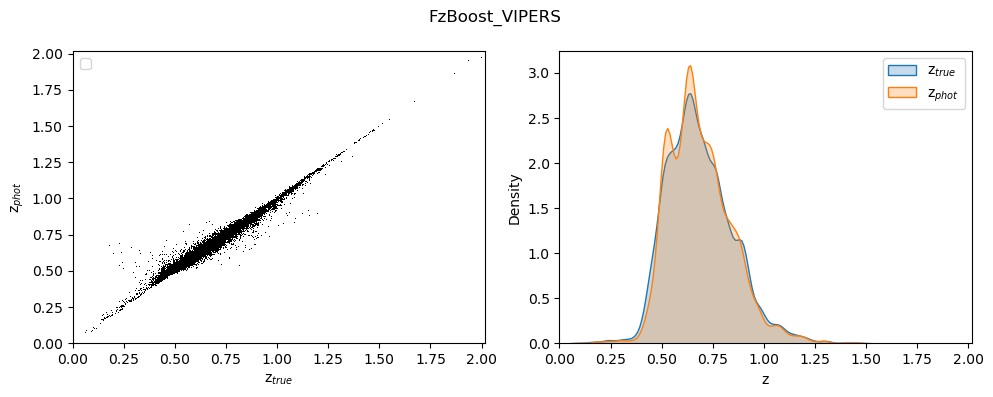

In [24]:
plot_old_valid(zphot,ztrue,catalog)


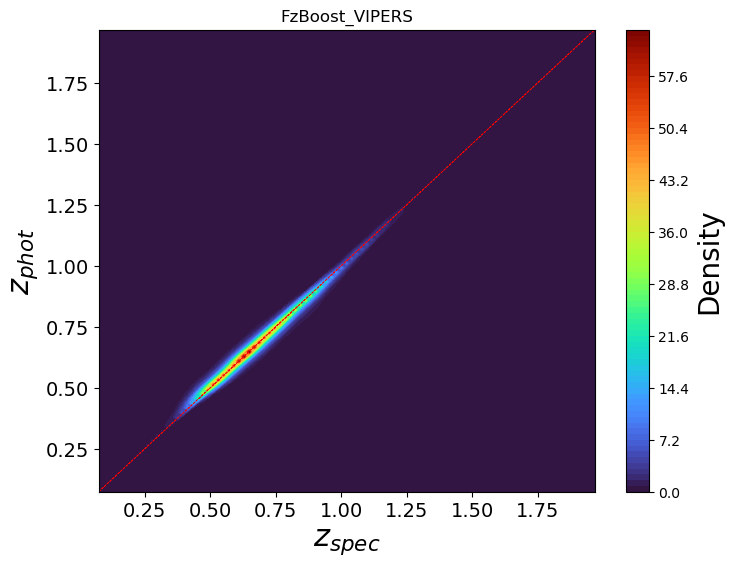

In [25]:
plot_scatter(ztrue,zphot,catalog)

### Metrics

In [26]:
old_metrics_table(zphot,ztrue)

|Metric | |DC1 paper
|:---|---:|---:
|scatter |     0.0096 |  0.0154
|bias |   -0.00007 | -0.00027
|outlier rate |      0.005 |  0.020

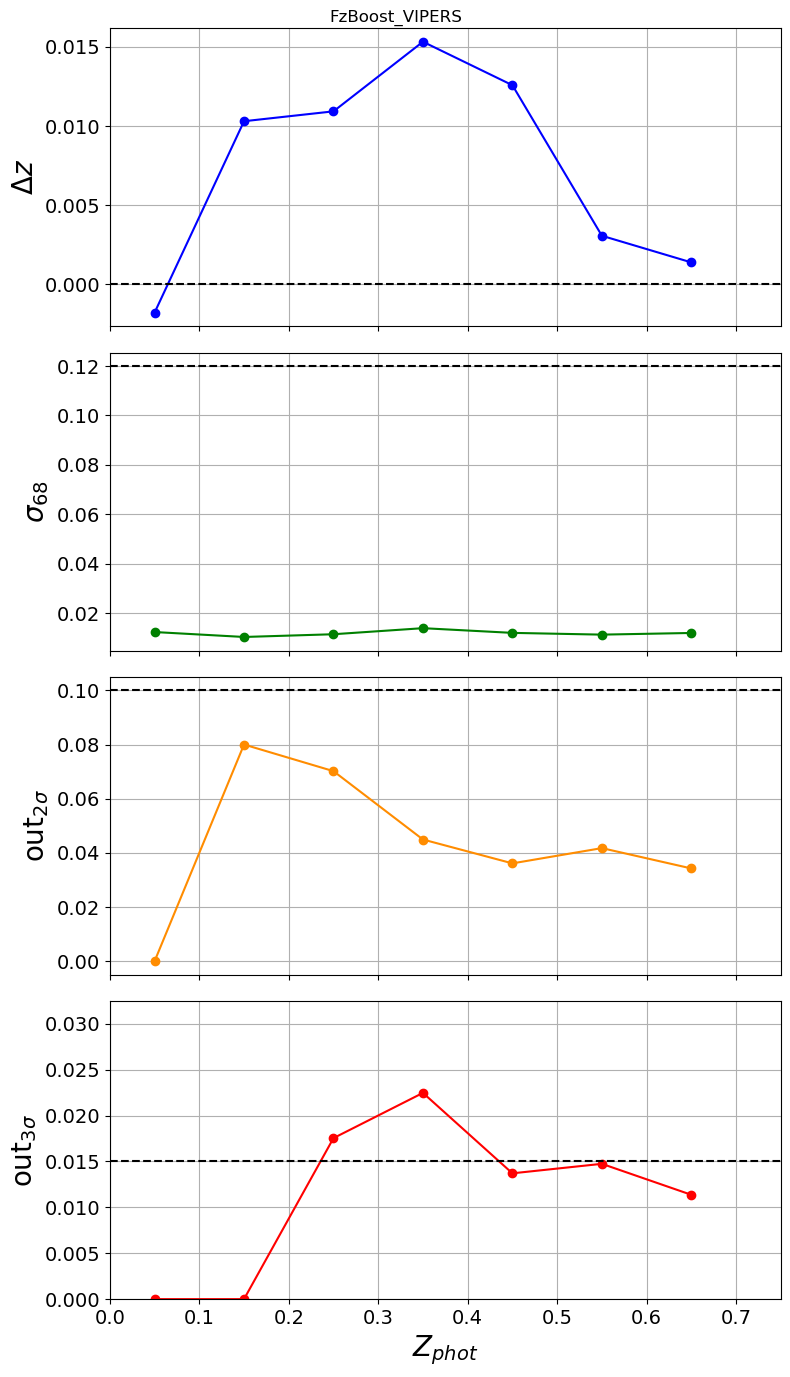

In [27]:
plot_metrics(ztrue,zphot,0.8,initial=0,title=f'FzBoost_{catalog}')

### N(z)

In [28]:
point_estimate_test = PointEstHistSummarizer.make_stage(name="point_estimate_test")
naive_stack_test = NaiveStackSummarizer.make_stage(name="naive_stack_test")


In [29]:
naive_stack_ens = naive_stack_test.summarize(output_fzb)

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 21873
Inserting handle into data store.  output_naive_stack_test: inprogress_output_naive_stack_test.hdf5, naive_stack_test
Inserting handle into data store.  single_NZ_naive_stack_test: inprogress_single_NZ_naive_stack_test.hdf5, naive_stack_test


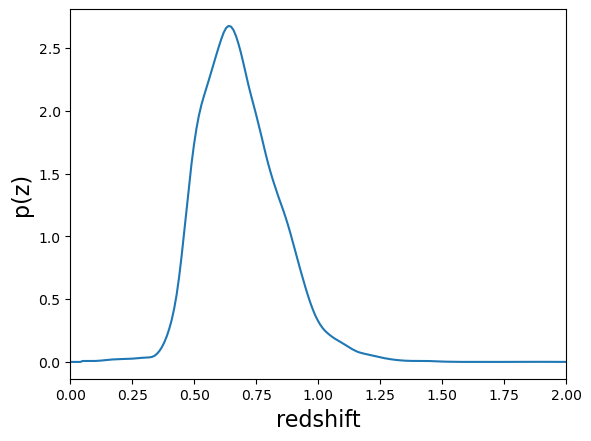

In [34]:
_ = naive_stack_ens.data.plot_native(xlim=(0, 2))

## Saving results

In [35]:
output_fzb().write_to(f'/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/results/results_fzb_control_{catalog}.hdf5')